In [1]:
ors = 2

In [2]:
import sys
sys.path.append('../_amigocloud')
import simplekml
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import os

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11180\3306260662.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# RUTA ONEDRIVE
ruta_data = r'G:'
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# leer los dos shps de siembra y puntos de planificacion
path_cat = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_puntos = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PUNTOS_PLAN.shp'
path_plan = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PLANIFICACION.shp'
path_xlsx_parte = ruta_data + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\parte_diario_pulverizacion.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [4]:
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [5]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,obs,procesado,geometry
1,633,AGROP. VICENTE ROCA GIL SRL,2,None,None,"MULTIPOINT (496512.874 8089555.085, 496620.816..."


In [6]:
multipoint_gdf = gdf_puntos_sem.copy()

In [7]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [8]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,obs,procesado,geometry
1,633,AGROP. VICENTE ROCA GIL SRL,2,None,None,POINT (496512.874 8089555.085)
1,633,AGROP. VICENTE ROCA GIL SRL,2,None,None,POINT (496620.816 8089899.961)
1,633,AGROP. VICENTE ROCA GIL SRL,2,None,None,POINT (497199.988 8089941.459)
1,633,AGROP. VICENTE ROCA GIL SRL,2,None,None,POINT (507591.477 8096464.774)
1,633,AGROP. VICENTE ROCA GIL SRL,2,None,None,POINT (507743.056 8095943.102)


<Axes: >

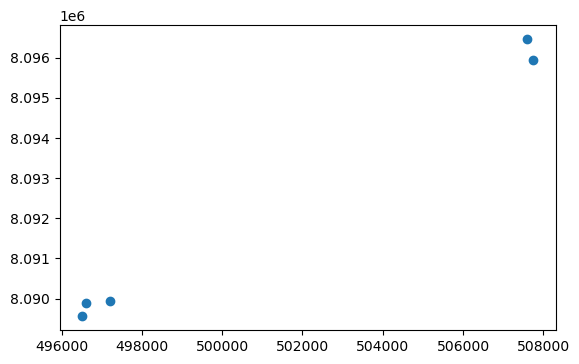

In [9]:
puntos_indi.plot()

In [10]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [11]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [12]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
3204,33.0,SANTA ANA--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L2.3,19.763782,2.0,40,"POLYGON ((507735.083 8096341.125, 507750.464 8..."
3219,33.0,SANTA ANA--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L2.4,9.528110,2.0,40,"POLYGON ((507554.965 8096742.911, 507600.491 8..."
9878,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L12,14.514214,0.0,40,"POLYGON ((496809.973 8090150.519, 496832.196 8..."
9927,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L12.2,27.498832,0.0,40,"POLYGON ((496864.451 8089734.277, 496896.798 8..."
9997,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L13,22.264854,0.0,40,"POLYGON ((497615.854 8090078.032, 497650.219 8..."


In [13]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [14]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
3204,33.0,SANTA ANA--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L2.3,19.763782,2.0,40,"POLYGON ((507735.083 8096341.125, 507750.464 8..."
3219,33.0,SANTA ANA--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L2.4,9.528110,2.0,40,"POLYGON ((507554.965 8096742.911, 507600.491 8..."
9878,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L12,14.514214,0.0,40,"POLYGON ((496809.973 8090150.519, 496832.196 8..."
9927,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L12.2,27.498832,0.0,40,"POLYGON ((496864.451 8089734.277, 496896.798 8..."
9997,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L13,22.264854,0.0,40,"POLYGON ((497615.854 8090078.032, 497650.219 8..."


In [15]:
# agrega los campos faltantes
poligonos_intersect_cat['os'] = ors

In [16]:
plan = poligonos_intersect_cat.copy()

In [17]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os
3204,33.0,SANTA ANA--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L2.3,19.763782,2.0,40,"POLYGON ((507735.083 8096341.125, 507750.464 8...",2
3219,33.0,SANTA ANA--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L2.4,9.528110,2.0,40,"POLYGON ((507554.965 8096742.911, 507600.491 8...",2
9878,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L12,14.514214,0.0,40,"POLYGON ((496809.973 8090150.519, 496832.196 8...",2
9927,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L12.2,27.498832,0.0,40,"POLYGON ((496864.451 8089734.277, 496896.798 8...",2
9997,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L13,22.264854,0.0,40,"POLYGON ((497615.854 8090078.032, 497650.219 8...",2


<Axes: >

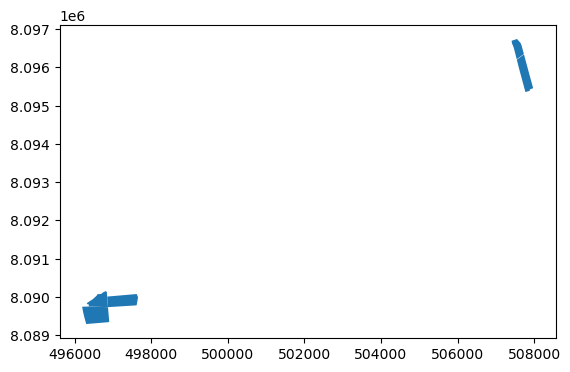

In [18]:
plan.plot()

In [19]:
plan['area'].sum()

93.56979317862077

In [20]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [21]:
plan['area'].sum()

93.56979317862077

In [22]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [23]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [24]:
last_id

15

In [25]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [26]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
3204,33.0,SANTA ANA--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L2.3,19.763782,2.0,40,"POLYGON ((507735.083 8096341.125, 507750.464 8...",2,16
3219,33.0,SANTA ANA--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L2.4,9.528110,2.0,40,"POLYGON ((507554.965 8096742.911, 507600.491 8...",2,17
9878,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L12,14.514214,0.0,40,"POLYGON ((496809.973 8090150.519, 496832.196 8...",2,18
9927,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L12.2,27.498832,0.0,40,"POLYGON ((496864.451 8089734.277, 496896.798 8...",2,19
9997,31.0,NAVIDAD--ROCA GIL VICENTE,633.0,AGROP. VICENTE ROCA GIL SRL,L13,22.264854,0.0,40,"POLYGON ((497615.854 8090078.032, 497650.219 8...",2,20


In [27]:
len(plan)

5

In [28]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

In [29]:
gdf_pla_gral['area'].sum()

415.7851271599349

In [30]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [31]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,os,soca,id,inst,idd,geometry
0,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,1,2,1,50,1.0,"POLYGON ((504085.659 8094406.031, 503737.808 8..."
1,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,1,4,2,50,1.0,"POLYGON ((504352.053 8094797.970, 504272.088 8..."
2,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,1,5,3,50,1.0,"POLYGON ((503260.583 8094596.306, 503714.735 8..."
3,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,1,4,4,50,1.0,"POLYGON ((504693.348 8094607.629, 504673.327 8..."
4,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,1,5,5,50,1.0,"POLYGON ((504137.327 8094415.183, 504648.080 8..."
5,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L5,10.318332,1,5,6,50,1.0,"POLYGON ((502800.712 8094558.618, 502817.481 8..."
6,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L9,26.783587,1,3,7,50,1.0,"POLYGON ((502151.946 8095089.317, 502180.927 8..."
7,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L15,17.950658,1,2,8,50,1.0,"POLYGON ((501079.860 8094856.577, 501419.672 8..."
8,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L7,15.371285,1,2,9,50,1.0,"POLYGON ((501510.045 8095556.280, 501495.788 8..."
9,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L10,26.586339,1,2,10,50,1.0,"POLYGON ((502549.761 8095663.451, 503187.898 8..."


In [32]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [33]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [34]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [35]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [36]:
len(gdf_pla_gral)

5

In [37]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/35248/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_360912 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CARGAR XLSX

In [38]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [39]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [40]:
excel_data = pd.read_excel(path_xlsx_parte)

In [41]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
3204,33,SANTA ANA--ROCA GIL VICENTE,633,AGROP. VICENTE ROCA GIL SRL,L2.3,19.763782,2,40,"MULTIPOLYGON (((-62.92725 -17.21787, -62.92710...",2,16
3219,33,SANTA ANA--ROCA GIL VICENTE,633,AGROP. VICENTE ROCA GIL SRL,L2.4,9.528110,2,40,"MULTIPOLYGON (((-62.92894 -17.21424, -62.92851...",2,17
9878,31,NAVIDAD--ROCA GIL VICENTE,633,AGROP. VICENTE ROCA GIL SRL,L12,14.514214,0,40,"MULTIPOLYGON (((-63.03001 -17.27384, -63.02980...",2,18
9927,31,NAVIDAD--ROCA GIL VICENTE,633,AGROP. VICENTE ROCA GIL SRL,L12.2,27.498832,0,40,"MULTIPOLYGON (((-63.02950 -17.27760, -63.02920...",2,19
9997,31,NAVIDAD--ROCA GIL VICENTE,633,AGROP. VICENTE ROCA GIL SRL,L13,22.264854,0,40,"MULTIPOLYGON (((-63.02243 -17.27450, -63.02211...",2,20


In [42]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [43]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS
0,40,633,AGROP. VICENTE ROCA GIL SRL,33,SANTA ANA--ROCA GIL VICENTE,L2.3,19.763782,2,16,2
1,40,633,AGROP. VICENTE ROCA GIL SRL,33,SANTA ANA--ROCA GIL VICENTE,L2.4,9.528110,2,17,2
2,40,633,AGROP. VICENTE ROCA GIL SRL,31,NAVIDAD--ROCA GIL VICENTE,L12,14.514214,0,18,2
3,40,633,AGROP. VICENTE ROCA GIL SRL,31,NAVIDAD--ROCA GIL VICENTE,L12.2,27.498832,0,19,2
4,40,633,AGROP. VICENTE ROCA GIL SRL,31,NAVIDAD--ROCA GIL VICENTE,L13,22.264854,0,20,2


In [44]:
new_df['MEZCLA'] = 0
new_df['LABOR_REALIZADA'] = 'PUL. CON DRONE'
new_df['Nº DE LABOR'] = 'PA-2025-1'

In [45]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS,MEZCLA,LABOR_REALIZADA,Nº DE LABOR
0,40,633,AGROP. VICENTE ROCA GIL SRL,33,SANTA ANA--ROCA GIL VICENTE,L2.3,19.763782,2,16,2,0,PUL. CON DRONE,PA-2025-1
1,40,633,AGROP. VICENTE ROCA GIL SRL,33,SANTA ANA--ROCA GIL VICENTE,L2.4,9.528110,2,17,2,0,PUL. CON DRONE,PA-2025-1
2,40,633,AGROP. VICENTE ROCA GIL SRL,31,NAVIDAD--ROCA GIL VICENTE,L12,14.514214,0,18,2,0,PUL. CON DRONE,PA-2025-1
3,40,633,AGROP. VICENTE ROCA GIL SRL,31,NAVIDAD--ROCA GIL VICENTE,L12.2,27.498832,0,19,2,0,PUL. CON DRONE,PA-2025-1
4,40,633,AGROP. VICENTE ROCA GIL SRL,31,NAVIDAD--ROCA GIL VICENTE,L13,22.264854,0,20,2,0,PUL. CON DRONE,PA-2025-1


In [46]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

In [47]:
final_data.to_excel(path_xlsx_parte, index=False)